# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from googletrans import Translator

# import math
# import nltk
# from nltk.corpus import wordnet

import missingno as msno

In [3]:
# pip install googletrans==4.0.0-rc1
# pip install missingno

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and file overview

#### 1-1. azdias

In [4]:
# 제출전 주석 해제
# # azdias

# azdias = pd.read_csv('../csv_pickle/Udacity_AZDIAS_052018.csv', sep=';')
# azdias.name = 'azdias'
# print (azdias.shape)
# azdias.head()

* load

In [22]:
azdias = pd.read_pickle('../csv_pickle/azdias.pickle')
azdias.name = 'azdias'
print (azdias.shape)
azdias.head()

(891221, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


* missing values

[function]

In [26]:
def miss_val_overview(df, chunk_size = 100):
    '''
    function to display missing value distribution
    df: dataframe
    chunk_size : size of column chunk, 100 as default  
    '''
    # split the columns into chunks
    chunk_size = chunk_size
    column_chunks = [df.iloc[:, i : i + chunk_size] for i in range(0, df.shape[1], chunk_size)]

    # Generate and display missingno plots for each chunk
    for i, _ in enumerate(column_chunks):
        msno.matrix(_, figsize = (10, 3), fontsize = 10, labels = False, sparkline = False)
        plt.title(
            f'missing value overview - column {i * 100} to {min (i * chunk_size + chunk_size - 1, df.shape[1] - 1)}',
            fontsize = 10);

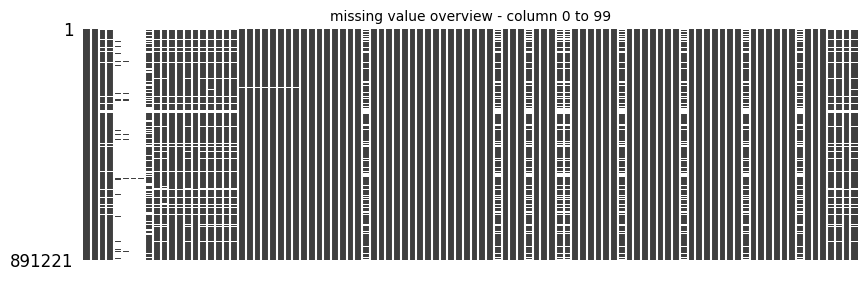

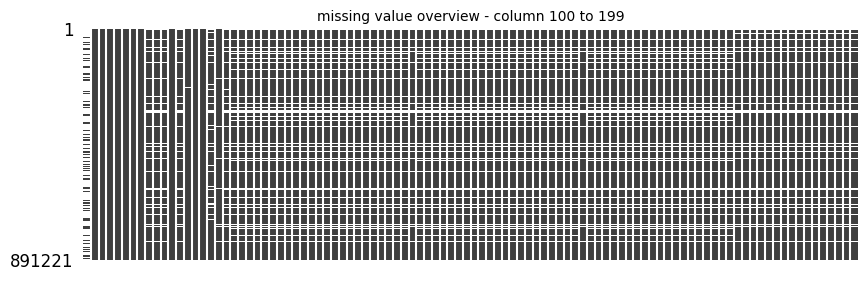

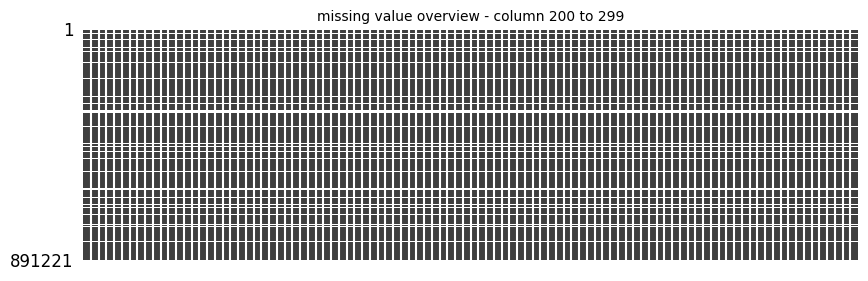

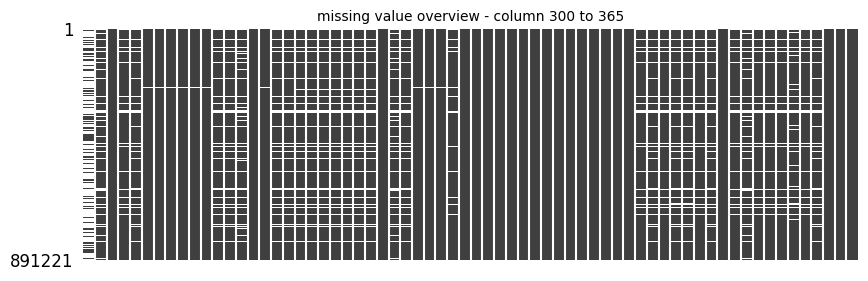

In [13]:
# missing value overview
miss_val_overview(azdias)

In [14]:
# 파이써닉 하지 못한 코드
# # missing value overview
# for i in range(0, ((azdias.shape[1] + 100) // 100) * 100, 100):
#     msno.matrix(azdias.iloc[:, i : i + 99],
#                 figsize=(10, 3), fontsize = 12, labels = False, sparkline = False)
#     plt.title('missing value overview: col ' + str (i) + ' to ' + str (min(i + 99, azdias.shape[1] - 1)),
#               fontsize = 12);

* missing values by column

[function]

In [27]:
def miss_val_hist(df, axis_val, xtick_bin = 10):
    '''
    function to display missing value histogram by column or raw
    df: dataframe
    axis_val: str, one of 'column' or 'row'
    xtick_bin : size of xtick bin, 10 as default 
    '''
    # axis value
    axis_num = 0 if axis_val == 'column' else 1
    
    # % of missing values
    missing_pct = df.isnull().mean(axis = axis_num) * 100

    # max % of missing values by column
    missing_pct_max = missing_pct.max()
    print ('max % of missing values by ' + axis_val + ': ', missing_pct_max)

    # plot missing values by column
    xtick_range = ((missing_pct_max + xtick_bin * 2) // xtick_bin) * xtick_bin

    ax = missing_pct.plot(
        kind = 'hist', figsize=(10, 3), color='gray',
        bins = np.arange(0, xtick_range, 10),
        title = (df.name + ': missing value by ' + axis_val)
        )
    ax.set_xlabel('% of missing value');

max % of missing values by column:  99.86479223447382


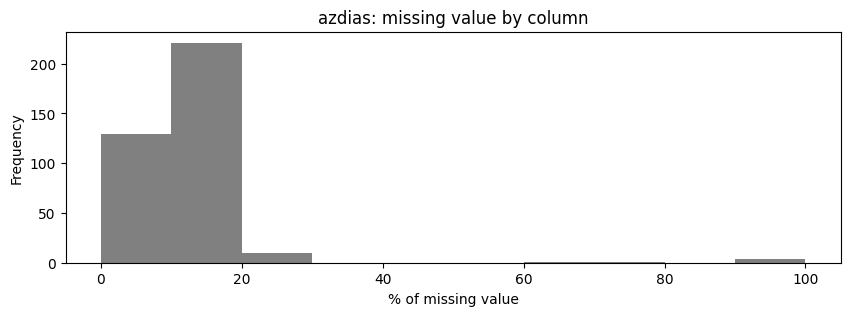

In [28]:
miss_val_hist(azdias, 'column')

In [30]:
# 함수화
# # missing values by column
# azdias_missing_pct_col = azdias.isnull().mean() * 100

# # max % of missing values by column
# azdias_missing_max_col = azdias_missing_pct_col.max()
# print ('max % of missing values by column:', azdias_missing_max_col)

# # plot missing values by column
# xtick_range = ((azdias_missing_max_col + 20) // 10) * 10

# ax = azdias_missing_pct_col.plot(
#     kind = 'hist', figsize=(10, 3), color='gray',
#     bins = np.arange(0, xtick_range, 10),
#     title = 'azdias: missing value in columns',
#     )
# ax.set_xlabel('% of missing value');

In [81]:
# % of columns with missing values of over 30%
(azdias.isnull().mean() * 100 > 30).mean()

0.01639344262295082

In [34]:
# % of columns with missing values of 25% to 30%
((azdias.isnull().mean() * 100 > 25) & (30 >= azdias.isnull().mean() * 100)).mean()

0.0273224043715847

> xxx colum, 891K row데이터 인데, 심하게 missing value 많은 컬럼이 있음  
> 

#### 1-2. customers

In [5]:
# 제출전 주석 해제
# # customers

# customers = pd.read_csv('../csv_pickle/Udacity_CUSTOMERS_052018.csv', sep=';')
# print (customers.info())
# customers.head()

In [6]:
customers = pd.read_pickle('../csv_pickle/customers.pickle')
print (customers.info())
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


#### 1-3. attributes_xlsx

In [7]:
# attributes_xlsx

attributes_xlsx = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

# 1st column has no info
attributes_xlsx = attributes_xlsx.iloc[:, 1:]

# only 1st lines of information have values 
attributes_xlsx[['Attribute', 'Description']] = attributes_xlsx[
    ['Attribute', 'Description']].fillna(method = 'ffill')

print (attributes_xlsx.info())
attributes_xlsx.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    2258 non-null   object
 1   Description  2258 non-null   object
 2   Value        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB
None


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [8]:
# attributes_xlsx

#### 1-4. information_xlsx

In [9]:
# information_xlsx

information_xlsx = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

# 1st column has no info
information_xlsx = information_xlsx.iloc[:, 1:]

# only 1st lines of information have values
information_xlsx['Information level'] = information_xlsx['Information level'].fillna(method = 'ffill')

print (information_xlsx.info())
information_xlsx.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  312 non-null    object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB
None


,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [10]:
# information_xlsx

### 2. File detail

#### 2-1. azdias: columns

In [11]:
# values of columns of azdias
col_val_azdias = pd.DataFrame(azdias.columns, columns=['Attribute'])
print (col_val_azdias.shape)

# add information on Attribute from Information_xlsx
col_val_azdias_desc = col_val_azdias.merge(information_xlsx, how = 'left')
print (col_val_azdias_desc.shape)

(366, 1)
(366, 4)


In [12]:
'''
For values of Attribute without Description, I added a column of
translation (ger_to_eng) using code below.
However as this code-running takes somewhat long time,
I saved the dataframe processed as col_val_azdias_desc.xlsx.
'''
# # For values of Attribute without Description, add colum of translation (ger_to_eng)
# def ger_to_eng (ger_text):
#     '''
#     function to translate German text
#     '''    
#     translator = Translator(service_urls=['translate.google.com'])    
#     try:
#         translation = translator.translate(ger_text, src='de', dest='en')
#         return translation.text        
#     except:
#         return np.nan

# col_val_azdias_desc['ger_to_eng'] = np.where(
#     col_val_azdias_desc.Description.isnull(),
#     col_val_azdias_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)

# # sort by Attribute and Information level
# col_val_azdias_desc.sort_values(by = ['Attribute', 'Information level'], inplace= True)

col_val_azdias_desc = pd.read_excel('col_val_azdias_desc.xlsx', index_col = [0])
col_val_azdias_desc.head(10)

,Attribute,Information level,Description,Additional notes,ger_to_eng
1,AGER_TYP,NaN,best-ager typology,in cooperation with Kantar TNS; the informatio...,NaN
2,AKT_DAT_KL,NaN,NaN,NaN,Act Dat KL
8,ALTERSKATEGORIE_FEIN,NaN,NaN,NaN,Age category fine
365,ALTERSKATEGORIE_GROB,Person,age through prename analysis,modelled on millions of first name-age-referen...,NaN
3,ALTER_HH,Household,main age within the household,NaN,NaN
4,ALTER_KIND1,NaN,NaN,NaN,Old child1
5,ALTER_KIND2,NaN,NaN,NaN,Old child2
6,ALTER_KIND3,NaN,NaN,NaN,Old child3
7,ALTER_KIND4,NaN,NaN,NaN,Old child4
364,ANREDE_KZ,Person,gender,NaN,NaN


In [13]:
# ### not to run ###

# # understand all columns of azdias one by one

# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
# col_val_azdias_desc

> 살펴 봤음. 모든 Attribute에 대해서 Information level과 Description을 completely 이해할 수는 없었으나   
> 대체적인 내용 구성을 이해할 수는 있었음   
> 비슷한 내용을 나타내는 중복열, 유사열이 많아 공선성 해소, 차원 축소가 필요함

#### 2-2. azdias: missing values

In [44]:
# 아마도 쓰지 않을 plot
# plot = azdias_col_missing_pct.plot(
#     kind = 'bar', figsize=(10, 3), color='dimgray', xticks = [],
#     title = 'azdias_col_missing_pct',
#     xlabel = '366 columns',
#     ylabel = '% of missing values')

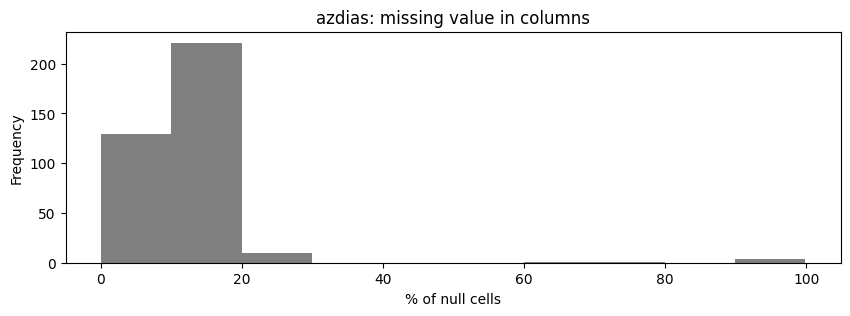

In [45]:
ax = azdias_missing_pct_col.plot(
    kind = 'hist', figsize=(10, 3), color='gray',
    title = 'azdias: missing value in columns',
    )
ax.set_xlabel('% of missing value');

##### 2-2-2. missing values by row

In [56]:
azdias_missing_pct_row = azdias.isnull().mean(axis = 1) * 100
print (azdias_missing_pct_row.max())
azdias_missing_pct_row

70.76502732240438


0         68.852459
1          4.098361
2          1.366120
3          1.912568
4          1.366120
            ...    
891216     3.005464
891217     1.639344
891218     2.185792
891219     1.092896
891220     4.371585
Length: 891221, dtype: float64

In [52]:
np.arange(0, 110, 10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

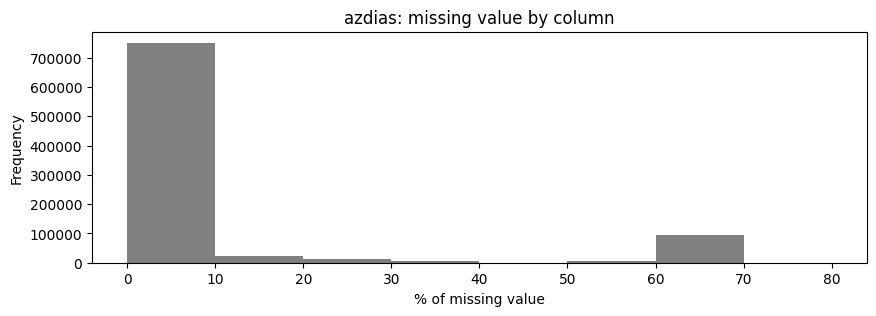

In [61]:
ax = azdias_missing_pct_row.plot(
    kind = 'hist', figsize=(10, 3), color='gray',
    bins = np.arange(0, 90, 10),
    title = 'azdias: missing value by column',
    )
ax.set_xlabel('% of missing value');

In [ ]:
# # plot = azdias_col_missing_pct.plot(kind = 'bar', figsize=(8, 6), legend=False);
# plot = azdias_row_missing_pct.plot(kind = 'bar', figsize=(10, 3), color='dimgray');
# # plot.xaxis.set_visible(False)

# plot.set_title('azdias_row_missing_pct')
# plot.set_xlabel('891K rows')
# plot.set_ylabel('% of missing values')
# plot.set_xticklabels([]);

#### 2-3. column contents

#### 2-1. attributes_xlsx

In [ ]:
col_val(attributes_xlsx)

In [ ]:
w_list = list(attributes_xlsx.Meaning.unique())

In [ ]:
nltk.download('wordnet')

In [ ]:
ambiguous_words = []

for synset in w_list:
    if len(synset.lemmas()) > 1:
        ambiguous_words.append(synset.name().split('.')[0])

In [ ]:
list(wordnet.all_synsets())

In [ ]:
synsets = wordnet.synsets('unknown')
synsets

In [ ]:
synonyms = []

for synset in synsets:
    for lemma in synset.lemmas():
        synonyms.append(lemma.name())
synonyms

In [ ]:
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Define the target word
target_word = 'unidentified'

# Retrieve synsets for the target word
synsets = wordnet.synsets(target_word)

# # Retrieve synonyms for each synset and filter out synonyms containing the target word
# filtered_synonyms = []

# for synset in synsets:
#     synonyms = synset.lemmas()
#     filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# # Remove duplicate synonyms and sort the list
# filtered_synonyms = sorted(set(filtered_synonyms))

# print(filtered_synonyms)

In [ ]:
filtered_synonyms = []

for synset in synsets:
    synonyms = synset.lemmas()
    filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

# Remove duplicate synonyms and sort the list
filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
for target_word in filtered_synonyms:
    # # Define the target word
    # target_word = 'unidentified'

    # Retrieve synsets for the target word
    synsets = wordnet.synsets(target_word)

    for synset in synsets:
        synonyms = synset.lemmas()
        filtered_synonyms.extend([synonym.name() for synonym in synonyms if target_word not in synonym.name()])

    # Remove duplicate synonyms and sort the list
    filtered_synonyms = sorted(set(filtered_synonyms))

print(filtered_synonyms)

In [ ]:
# customers

print (customers.info())
customers.head()

In [ ]:
# attributes_xlsx

print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# modify attributes_xlsx

attributes_xlsx = attributes_xlsx.iloc[:, 1:] # 1st column has no info
attributes_xlsx[['Attribute', 'Description']] = attributes_xlsx[
    ['Attribute', 'Description']].fillna(method = 'ffill')
print (attributes_xlsx.info())
attributes_xlsx.head(10)

In [ ]:
# information_xlsx

print (information_xlsx.info())
information_xlsx.head()

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
def col_val (df):
    '''
    function to check values of dataframe columns
    df : dataframe
    '''
    # for i in df.columns:
    #     print (i, '-', df[i].nunique(), 'values', '\n',
    #         df[i].value_counts(), '\n', '*     *     *')
    for i in df.columns:
        print (i, '-', df[i].nunique(), 'values', '\n',
        list(df[i].unique()), '\n', '*     *     *')

In [ ]:
# from googletrans import Translator

# Create an instance of the Translator
translator = Translator(service_urls=['translate.google.com'])

# Text to be translated
text = "AGER_TYP"

# Translate the text from German to English
translation = translator.translate(text, src='de', dest='en')

# Print the translated text
print("Original text (German):", text)
print("Translated text (English):", translation.text)